<a href="https://colab.research.google.com/github/MudassarAQazi/DL_Project_2_Sattelites_Ships_Imagery_Detection/blob/main/DL_Project_2_Ships_Sattelite_Imagery_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Observe TensorFlow speedup on GPU relative to CPU

This example constructs a typical convolutional neural network layer over a
random image and manually places the resulting ops on either the CPU or the GPU
to compare execution speed.

In [ ]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.112926794000032
GPU (s):
0.03871388200002457
GPU speedup over CPU: 80x


# **Loading And Reshaping the Data**

In [ ]:
import numpy as np
from numpy import expand_dims
import pandas as pd
import json
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
import keras
from tensorflow.keras.layers import BatchNormalization
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
EPOCHS = 3
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = "../content/drive/MyDrive/PlantVillage"
# directory_root = "Downloads\DL\PlantVillage"
width=80
height=80
depth=3

In [ ]:
with open('../content/drive/MyDrive/Dataset/shipsnet.json') as data_file:
    dataset = json.load(data_file)
shipsnet= pd.DataFrame(dataset)
shipsnet.head()

,data,labels,locations,scene_ids
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007


In [ ]:
shipsnet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   data       4000 non-null   object
 1   labels     4000 non-null   int64 
 2   locations  4000 non-null   object
 3   scene_ids  4000 non-null   object
dtypes: int64(1), object(3)
memory usage: 125.1+ KB


> We need just two columns in this project which are data and labels.
> 

In [ ]:
shipsnet = shipsnet[["data", "labels"]]
shipsnet.head()

,data,labels
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1


In [ ]:
len(shipsnet["data"].iloc[0])

19200

As you can see, the pixel value data for each 80x80 RGB image is stored as a list of 19200 integers within the data list. The first 6400 entries contain the red channel values, the next 6400 the green, and the final 6400 the blue.

In [ ]:
ship_images = shipsnet["labels"].value_counts()[0]
no_ship_images = shipsnet["labels"].value_counts()[1]
print("Number of the ship_images :{}".format(ship_images),"\n")
print("Number of the no ship_images :{}".format(no_ship_images))

Number of the ship_images :3000 

Number of the no ship_images :1000


In [ ]:
# Turning the json information into numpy array and then assign it as x and y variables
x = np.array(dataset['data']).astype('uint8')
y = np.array(dataset['labels']).astype('uint8')

In [ ]:
x.shape

(4000, 19200)

The current data for each image is one row of flattened 19200 data points representing the RGB values of each pixel. So we need to reshape it. After reshaping, each item in new x variable will be 3 lists. Each of these lists will be RGB values for each pixel for the length and width of the image.

In [ ]:
x_reshaped = x.reshape([-1, 3, 80, 80])

In [ ]:
x_reshaped.shape

(4000, 3, 80, 80)

In [ ]:
x_reshaped = x.reshape([-1, 3, 80, 80]).transpose([0,2,3,1])
x_reshaped.shape

(4000, 80, 80, 3)

y variable consist of label values, 1 or 0. We need to convert them binary class matrix.

In [ ]:
y.shape

(4000,)

In [ ]:
y_reshaped = to_categorical(y, num_classes=2)

y_reshaped.shape

(4000, 2)

In [ ]:
y_reshaped

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

# **DATA VISUALISATION**

# ****PIXEL **INTENSITY******

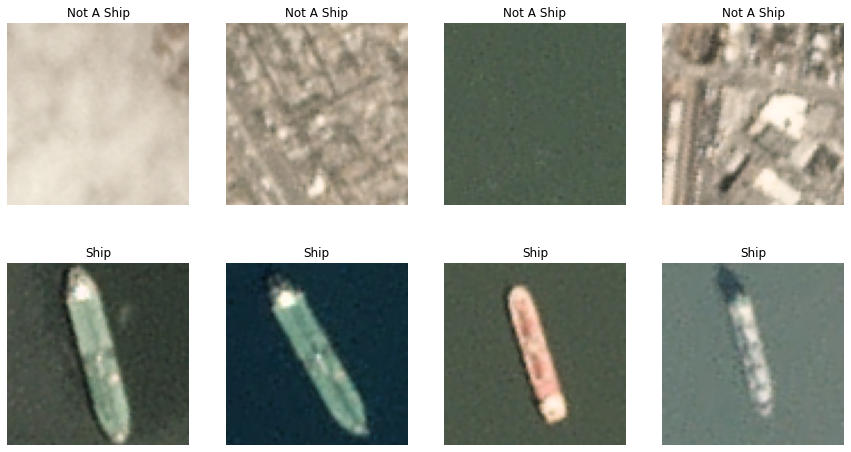

In [ ]:
image_no_ship = x_reshaped[y==0]
image_ship = x_reshaped[y==1]

def plot(a,b):
    
    plt.figure(figsize=(15, 15))
    for i, k in enumerate(range(1,9)):
        if i < 4:
            plt.subplot(2,4,k)
            plt.title('Not A Ship')
            plt.imshow(image_no_ship[i+2])
            plt.axis("off")
        else:
            plt.subplot(2,4,k)
            plt.title('Ship')
            plt.imshow(image_ship[i+15])
            plt.axis("off")
            
    plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0.25)

#Implementation of the function 

plot(image_no_ship, image_ship)

# **PIXEL INTENSITY**

In [ ]:
def plotHistogram(ship, not_ship):

    plt.figure(figsize = (10,7))
    plt.subplot(2,2,1)
    plt.imshow(ship)
    plt.axis('off')
    plt.title('Ship')
    histo = plt.subplot(2,2,2)
    histo.set_ylabel('Count', fontweight = "bold")
    histo.set_xlabel('Pixel Intensity', fontweight = "bold")
    n_bins = 30
    plt.hist(ship[:,:,0].flatten(), bins = n_bins, lw = 0, color = 'r', alpha = 0.5);
    plt.hist(ship[:,:,1].flatten(), bins = n_bins, lw = 0, color = 'g', alpha = 0.5);
    plt.hist(ship[:,:,2].flatten(), bins = n_bins, lw = 0, color = 'b', alpha = 0.5);
    plt.show()
    print("Minimum pixel value of this image: {}".format(ship.min()))
    print("Maximum pixel value of this image: {}".format(ship.max()))
    plt.figure(figsize = (10,7))
    plt.subplot(2,2,3)
    plt.imshow(not_ship)
    plt.axis('off')
    plt.title('Not A Ship')
    histo = plt.subplot(2,2,4)
    histo.set_ylabel('Count', fontweight = "bold")
    histo.set_xlabel('Pixel Intensity', fontweight = "bold")
    n_bins = 30
    plt.hist(not_ship[:,:,0].flatten(), bins = n_bins, lw = 0, color = 'r', alpha = 0.5);
    plt.hist(not_ship[:,:,1].flatten(), bins = n_bins, lw = 0, color = 'g', alpha = 0.5);
    plt.hist(not_ship[:,:,2].flatten(), bins = n_bins, lw = 0, color = 'b', alpha = 0.5);
    plt.show()
    print("Minimum pixel value of this image: {}".format(not_ship.min()))
    print("Maximum pixel value of this image: {}".format(not_ship.max()))


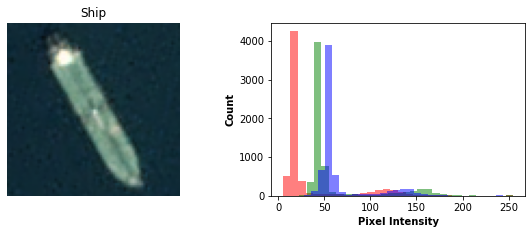

Minimum pixel value of this image: 5
Maximum pixel value of this image: 255


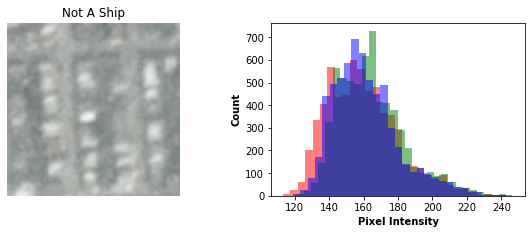

Minimum pixel value of this image: 113
Maximum pixel value of this image: 247


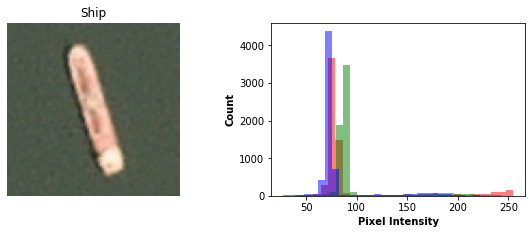

Minimum pixel value of this image: 27
Maximum pixel value of this image: 255


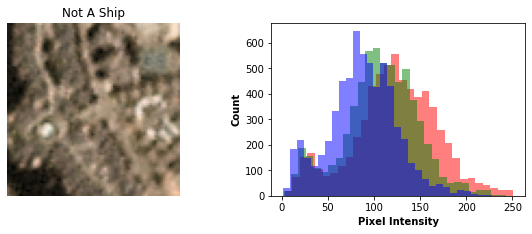

Minimum pixel value of this image: 1
Maximum pixel value of this image: 251


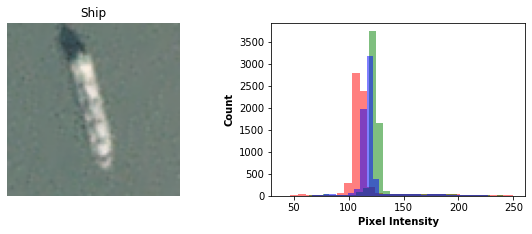

Minimum pixel value of this image: 40
Maximum pixel value of this image: 250


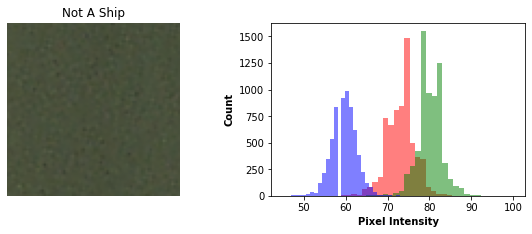

Minimum pixel value of this image: 45
Maximum pixel value of this image: 100


In [ ]:
#Implementation of the function
for i in range (20,23):
    plotHistogram(x_reshaped[y==1][i], x_reshaped[y==0][i])

# **CHANNEL VIEW**

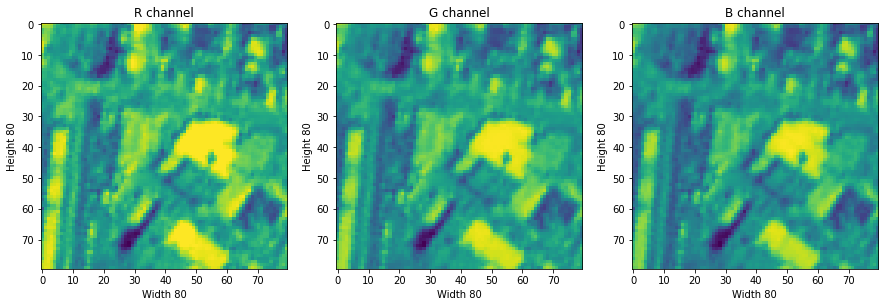

In [ ]:
my_list = [(0, 'R channel'), (1, 'G channel'), (2, 'B channel')]

plt.figure(figsize = (15,15))

for i, k in my_list:
    plt.subplot(1,3,i+1)
    plt.title(k)
    plt.ylabel('Height {}'.format(x_reshaped[y==0][5].shape[0]))
    plt.xlabel('Width {}'.format(x_reshaped[y==0][5].shape[1]))
    plt.imshow(x_reshaped[y==0][5][ : , : , i])

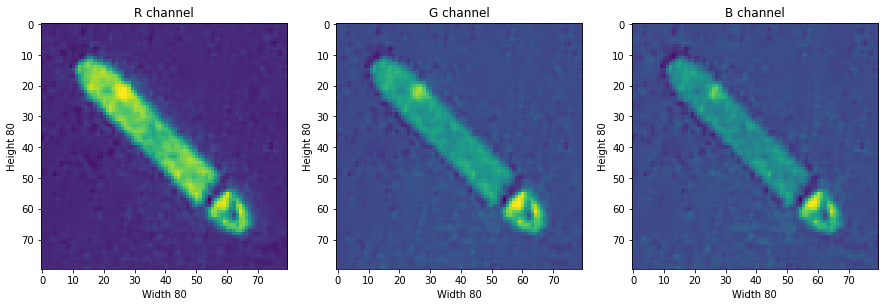

In [ ]:
my_list = [(0, 'R channel'), (1, 'G channel'), (2, 'B channel')]

plt.figure(figsize = (15,15))

for i, k in my_list:
    plt.subplot(1,3,i+1)
    plt.title(k)
    plt.ylabel('Height {}'.format(x_reshaped[y==0][5].shape[0]))
    plt.xlabel('Width {}'.format(x_reshaped[y==0][5].shape[1]))
    plt.imshow(x_reshaped[y==1][5][ : , : , i])

# **MODELING**

Preparing of Train and Test Data

* First step is normalizing x data.

In [ ]:
x_reshaped = x_reshaped / 255

In [ ]:
x_reshaped[0][0][0] # Normalized RGB values of the firs pixel of the first image in the dataset.


array([0.32156863, 0.36862745, 0.31372549])

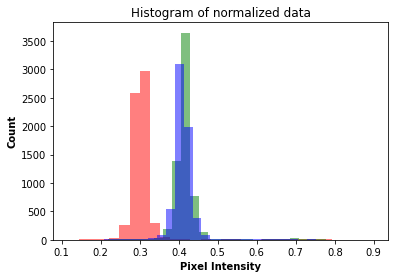

In [ ]:
n_bins = 30
plt.hist(x_reshaped[y == 0][0][:,:,0].flatten(), bins = n_bins, lw = 0, color = 'r', alpha = 0.5);
plt.hist(x_reshaped[y == 0][0][:,:,1].flatten(), bins = n_bins, lw = 0, color = 'g', alpha = 0.5);
plt.hist(x_reshaped[y == 0][0][:,:,2].flatten(), bins = n_bins, lw = 0, color = 'b', alpha = 0.5);
plt.ylabel('Count', fontweight = "bold")
plt.xlabel('Pixel Intensity', fontweight = "bold")
plt.title("Histogram of normalized data")
plt.show()

* Data is ready for splitting as train and test.

In [ ]:
x_train_1, x_test, y_train_1, y_test = train_test_split(x_reshaped, y_reshaped,
                                                        test_size = 0.20, random_state = 42)


x_train, x_val, y_train, y_val = train_test_split(x_train_1, y_train_1, 
                                                  test_size = 0.25, random_state = 42)


print("x_train shape",x_train.shape)
print("x_test shape",x_test.shape)
print("y_train shape",y_train.shape)
print("y_test shape",y_test.shape)
print("y_train shape",x_val.shape)
print("y_test shape",y_val.shape)



x_train shape (2400, 80, 80, 3)
x_test shape (800, 80, 80, 3)
y_train shape (2400, 2)
y_test shape (800, 2)
y_train shape (800, 80, 80, 3)
y_test shape (800, 2)


In [ ]:
keras.backend.clear_session()

# **8-Layer CNN IMPLEMENTATION**

In [ ]:
from tensorflow import keras as k
n_classes = 2;
inputShape = (height, width, depth)
chanDim = -1
from keras import callbacks
model = Sequential()
# Conv1
model.add(Conv2D(filters = 64, kernel_size = (7,7),padding = 'Same', input_shape = (80,80,3)))
model.add(k.layers.LeakyReLU(alpha=0.05))
model.add(BatchNormalization(axis=chanDim))
# Pool1
model.add(MaxPool2D(pool_size=(3, 3), padding = "same"))
model.add(Dropout(0.25))
# Conv2
model.add(Conv2D(256, (3, 3), padding="same",input_shape=inputShape))
model.add(k.layers.LeakyReLU(alpha=0.05))
model.add(BatchNormalization(axis=chanDim))
# Conv3
model.add(Conv2D(384, (7, 7), padding="same",input_shape=inputShape))
model.add(k.layers.LeakyReLU(alpha=0.05))
model.add(BatchNormalization(axis=chanDim))
# Conv4
model.add(Conv2D(384, (9, 9), padding="same",input_shape=inputShape))
model.add(k.layers.LeakyReLU(alpha=0.05))
model.add(BatchNormalization(axis=chanDim))
# Conv5
model.add(Conv2D(384, (3, 3), padding="same",input_shape=inputShape))
model.add(k.layers.LeakyReLU(alpha=0.05))
model.add(BatchNormalization(axis=chanDim))
# Pool5
model.add(MaxPool2D(pool_size=(3, 3), padding = "same"))
model.add(Dropout(0.25))
# Conv6
model.add(Conv2D(256, (3, 3), padding="same",input_shape=inputShape))
model.add(k.layers.LeakyReLU(alpha=0.05))
model.add(BatchNormalization(axis=chanDim))
# Pool6
model.add(MaxPool2D(pool_size=(3, 3), padding = "same"))
model.add(Dropout(0.25))
# Flatten
model.add(Flatten())
# FC7
model.add(Dense(512))
model.add(k.layers.LeakyReLU(alpha=0.05))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# FC8
model.add(Dense(n_classes, activation = "softmax"))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 80, 64)        9472      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 80, 80, 64)        0         
                                                                 
 batch_normalization (BatchN  (None, 80, 80, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 27, 27, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       1

In [ ]:
from keras.utils.vis_utils import plot_model

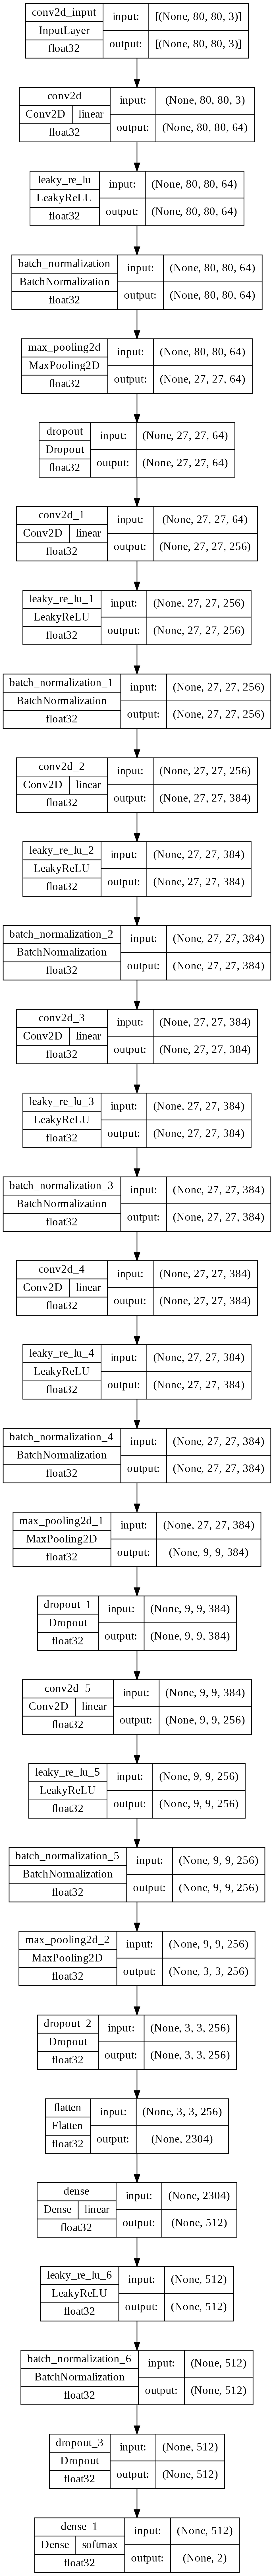

In [ ]:
plot_model(model, 
           to_file = '../content/drive/MyDrive/DL_Project_2_Ships_Sattelite_Imagery_Detection_model.png', 
           show_shapes  = True,
           show_dtype   = True,
           show_layer_names = True,
           rankdir  = 'TB',
           expand_nested  = True,
           dpi=200, 
           show_layer_activations = True)

In [ ]:
# !pip install onnxruntime

In [ ]:
# !pip install -U tf2onnx

In [ ]:
# %cd /content/drive/MyDrive

In [ ]:
# model.save('saved_model_tf')

In [ ]:
# !python -m tf2onnx.convert --saved-model saved_model_tf --output model.onnx

In [ ]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 10, 
                                        restore_best_weights = True)
history = model.fit(x_train, y_train, epochs = 100, validation_data=(x_val, y_val), callbacks = [earlystopping])

Epoch 1/100
75/75 [==============================] - 34s 350ms/step - loss: 0.5224 - accuracy: 0.8188 - val_loss: 5.7475 - val_accuracy: 0.2488
Epoch 2/100
75/75 [==============================] - 26s 347ms/step - loss: 0.2305 - accuracy: 0.9142 - val_loss: 0.3401 - val_accuracy: 0.8712
Epoch 3/100
75/75 [==============================] - 26s 348ms/step - loss: 0.1429 - accuracy: 0.9475 - val_loss: 0.3565 - val_accuracy: 0.8637
Epoch 4/100
75/75 [==============================] - 27s 366ms/step - loss: 0.1050 - accuracy: 0.9608 - val_loss: 0.4153 - val_accuracy: 0.8725
Epoch 5/100
75/75 [==============================] - 28s 370ms/step - loss: 0.0993 - accuracy: 0.9621 - val_loss: 0.4062 - val_accuracy: 0.8737
Epoch 6/100
75/75 [==============================] - 27s 361ms/step - loss: 0.0819 - accuracy: 0.9708 - val_loss: 0.5836 - val_accuracy: 0.8550
Epoch 7/100
75/75 [==============================] - 27s 362ms/step - loss: 0.0658 - accuracy: 0.9787 - val_loss: 0.2080 - val_accuracy:

In [ ]:
model.evaluate(x_test, y_test)

25/25 [==============================] - 2s 67ms/step - loss: 0.0278 - accuracy: 0.9912


[0.027829134836792946, 0.9912499785423279]

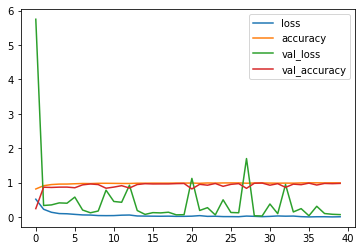

In [ ]:
pd.DataFrame(history.history).plot();

# **Data Augmentation.**

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False, 
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False,  
        zca_whitening=False,
        rotation_range=5,  
        zoom_range = 0.1,
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=False, 
        vertical_flip=False)  

datagen.fit(x_train)

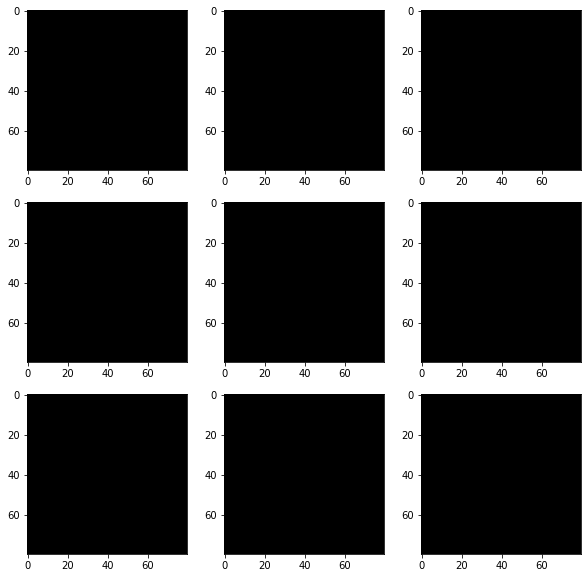

In [ ]:
data = x_reshaped[y==1][15]
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datag = ImageDataGenerator(brightness_range=[0.2,1.0],
                          zoom_range=[0.5,1.0],
                          horizontal_flip=True,
                          rotation_range=90)
# prepare iterator
it = datag.flow(samples, batch_size=1)
# generate samples and plot
plt.figure(figsize = (10,10))
for i in range(9):
    # define subplot
    plt.subplot(3,3,i+1)
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    # plot raw pixel data
    plt.imshow(image)
    # show the figure
plt.show()

In [ ]:
history = model.fit(datagen.flow(x_train, y_train), epochs = 100, 
                    validation_data=(x_val, y_val), callbacks = [earlystopping])

Epoch 1/100
75/75 [==============================] - 28s 359ms/step - loss: 0.0536 - accuracy: 0.9817 - val_loss: 0.5831 - val_accuracy: 0.8950
Epoch 2/100
75/75 [==============================] - 27s 360ms/step - loss: 0.0477 - accuracy: 0.9808 - val_loss: 0.0479 - val_accuracy: 0.9800
Epoch 3/100
75/75 [==============================] - 27s 360ms/step - loss: 0.0534 - accuracy: 0.9808 - val_loss: 0.0506 - val_accuracy: 0.9837
Epoch 4/100
75/75 [==============================] - 27s 355ms/step - loss: 0.0446 - accuracy: 0.9862 - val_loss: 0.0785 - val_accuracy: 0.9800
Epoch 5/100
75/75 [==============================] - 27s 366ms/step - loss: 0.0575 - accuracy: 0.9821 - val_loss: 0.7185 - val_accuracy: 0.8625
Epoch 6/100
75/75 [==============================] - 28s 376ms/step - loss: 0.0372 - accuracy: 0.9871 - val_loss: 0.1243 - val_accuracy: 0.9588
Epoch 7/100
75/75 [==============================] - 28s 372ms/step - loss: 0.0444 - accuracy: 0.9867 - val_loss: 0.0653 - val_accuracy:

In [ ]:
model.evaluate(x_test, y_test)

25/25 [==============================] - 2s 69ms/step - loss: 0.0168 - accuracy: 0.9962


[0.016797823831439018, 0.9962499737739563]

In [ ]:
import pickle
print(pickle.__doc__)

Create portable serialized representations of Python objects.

See module copyreg for a mechanism for registering custom picklers.
See module pickletools source for extensive comments.

Classes:

    Pickler
    Unpickler

Functions:

    dump(object, file)
    dumps(object) -> string
    load(file) -> object
    loads(string) -> object

Misc variables:

    __version__
    format_version
    compatible_formats




In [ ]:
model.save("/content/drive/MyDrive/DL_Project_2_Ships_Sattelite_Imagery_Detection.h5")
print("Saved Model to Google Drive...")

Saved Model to Google Drive...


In [ ]:
from tensorflow.keras.models import load_model
#Load Model
model = load_model("/content/drive/MyDrive/DL_Project_2_Ships_Sattelite_Imagery_Detection.h5")
history = model.history

25/25 [==============================] - 0s 6ms/step

Test Accuracy Score :  0.98 



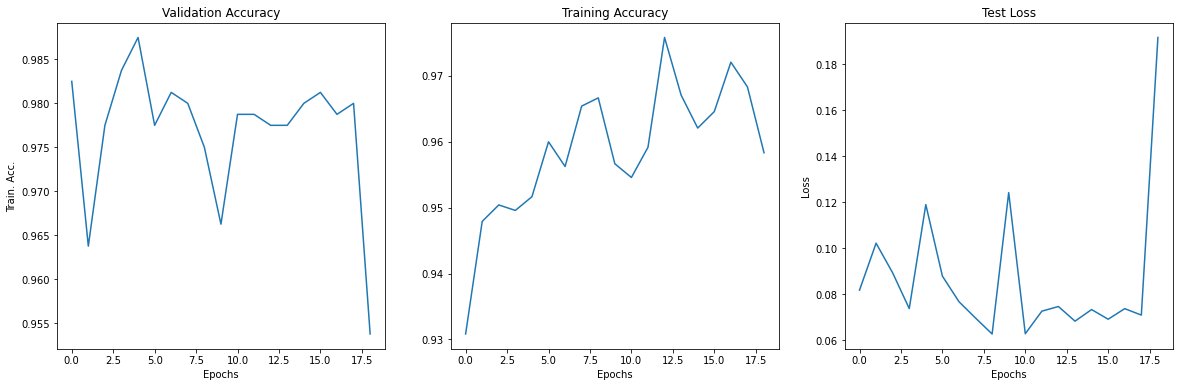

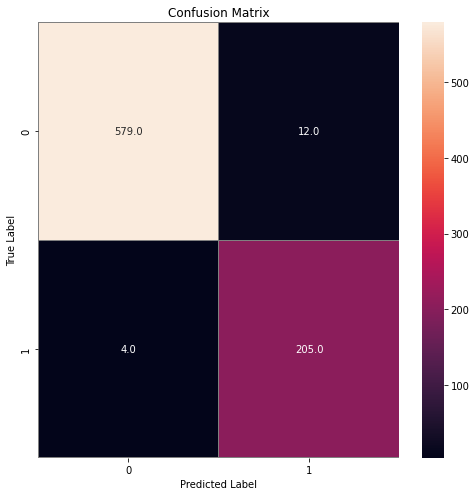

In [ ]:
from sklearn import metrics
import seaborn as sns
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# Compute the confusion matrix

print("\n""Test Accuracy Score : ",metrics.accuracy_score(Y_true, Y_pred_classes),"\n")

fig, axis = plt.subplots(1, 3, figsize=(20,6))
axis[0].plot(history.history['val_accuracy'], label='val_acc')
axis[0].set_title("Validation Accuracy")
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Val. Acc.")
axis[1].plot(history.history['accuracy'], label='acc')
axis[1].set_title("Training Accuracy")
axis[1].set_xlabel("Epochs")
axis[0].set_ylabel("Train. Acc.")
axis[2].plot(history.history['val_loss'], label='val_loss')
axis[2].set_title("Test Loss")
axis[2].set_xlabel("Epochs")
axis[2].set_ylabel("Loss")

plt.show()

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# Plot the confusion matrix
f,ax = plt.subplots(figsize=(7, 7))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()

plt.show()